In [1]:
import os
import sys
sys.path.extend(['..'])

import itertools
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import tensorboard
%load_ext tensorboard

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()


print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [136]:
class Agent(tf.keras.Model):
    
    def __init__(
        self, 
        channel_size,
        num_classes,
        name='agent',
        lstm_units=64,
        latent_dim=64,
        dense_dim=128,
        encoder=None,
        output_activation=None,
        unknown_class=False,
        **kwargs
    ):
        super(Agent, self).__init__(name=name, **kwargs)
        self.state = None
        self.channel_size = channel_size
        self.num_classes = num_classes
        
        self.concat = tf.keras.layers.Concatenate()
        
        self.encoder = encoder or \
            tf.keras.layers.Lambda(lambda x: x)
        
        self.dense1 = tf.keras.layers.Dense(
            dense_dim, activation=output_activation
        )
        
        self.lstm = tf.keras.layers.LSTM(
            units=lstm_units,
            return_state=True,
            dropout=0.5,
        )

        self.unknown_class = unknown_class
        if self.unknown_class:
            output_size = self.channel_size + self.num_classes + 1
        else:
            output_size = self.channel_size + self.num_classes
        
        self.output_layer = tf.keras.layers.Dense(
            output_size, activation=output_activation
        )
        
        self.extract_utterance = tf.keras.layers.Lambda(
            lambda x: x[:, :self.channel_size]
        )
        self.extract_class_probs = tf.keras.layers.Lambda(
            lambda x: tf.nn.softmax(x[:, self.channel_size:])
        )
        
        self.reset()
        
    def reset(self):
        self.state = self.lstm.get_initial_state(inputs)

    def call(self, inputs, state=None, training=False):
        
        inp, prev_utt, other_utt = inputs
        
        x = self.encoder(inp)
        
        x = self.concat([x, prev_utt, other_utt])
        x = self.dense1(x)
        
        x = tf.expand_dims(x, 1) # Add time dim
        if state is None:
            state = self.state
        x, *state = self.lstm(x, initial_state=state, 
                              training=training)
        self.state = state
        
        x = self.output_layer(x, training=training)
        
        utterance = self.extract_utterance(x)
        class_probs = self.extract_class_probs(x)
        
        return utterance, class_probs, state


class CommChannel(tf.keras.layers.Layer):
    
    def __init__(self, 
                 size=32,
                 noise=0.5, 
                 temperature=1,
                 no_transform=False,
                 one_hot=True):
        super(CommChannel, self).__init__()
        self.size = size
        self.noise = noise
        self.temperature = temperature
        self.no_transform = no_transform
        self.one_hot = one_hot
        
    def get_initial_state(self, batch_size):
        return tf.zeros((batch_size, self.size))
        
    def call(self, x, training=False):
        if training:
            if self.no_transform:
                return x
            
            if self.noise > 0:
                x = x + tf.random.normal(tf.shape(x),  
                                         mean=tf.zeros_like(x), 
                                         stddev=self.noise)
                
            # The RelaxedOneHotCategorical distribution was concurrently introduced as the
            # Gumbel-Softmax (Jang et al., 2016) and Concrete (Maddison et al., 2016)
            # distributions for use as a reparameterized continuous approximation to the
            # `Categorical` one-hot distribution. If you use this distribution, please cite
            # both papers.
            dist = tfp.distributions.RelaxedOneHotCategorical(
                self.temperature, 
                logits=x
            )
            return dist.sample()
        
        else:
            if self.one_hot:
                x = tf.nn.softmax(x)
                
            x = tf.one_hot(tf.argmax(x, axis=-1), 
                           self.size, dtype=tf.float32)
            return x

## Check that gradients can flow across channel:

In [137]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.00199294 0.1239716  0.58607334 0.28796208]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [138]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [139]:
num_classes = 3
batch_size = 32
use_mnist = False
include_unknown_class = True

if use_mnist:
    class_labels = list(range(num_classes))
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    def preprocess_images(images):
        images = images / 255.
        return np.where(images > .5, 1.0, 0.0).astype('float32')

    x_train = preprocess_images(x_train)
    train_data = [(x, y) for x, y in zip(x_train, y_train) if y in class_labels]
    np.random.shuffle(train_data)

    x_test = preprocess_images(x_test)
    test_data = [(x, y) for x, y in zip(x_test, y_test) if y in class_labels]
    np.random.shuffle(test_data)
    
else:
    class_labels = list(range(1, 1 + num_classes))
    sample_size = int(np.ceil(np.log2(num_classes)))
    train_data = [
        ([0.0]*(sample_size - len(bin(l)) + 2) + [float(x) for x in bin(l)[2:]], l)
        for l in range(1, num_classes+1)
    ]
    test_data = train_data


train_data_by_label = {
    label: [
        img for img, l in train_data
        if l == label
    ]
    for label in class_labels
}

test_data_by_label = {
    label: [
        img for img, l in test_data
        if l == label
    ]
    for label in class_labels
}

In [140]:
train_data_by_label

{1: [[0.0, 1.0]], 2: [[1.0, 0.0]], 3: [[1.0, 1.0]]}

In [141]:
def generate_batch(source, source_by_label, batch_size=32):
    inputs = []
    targets = []
    
    
    for batch in range(batch_size):
        batch_tars = []
        batch_inps = []
        
        for ts in range(num_classes):
            sample_space = set(class_labels) - set(batch_tars)
            target = random.choice(list(sample_space))
            batch_tars.append(target)
            inp = random.choice(source_by_label[target])
            batch_inps.append(tf.constant(inp))
        
        target = random.choice(list(set(class_labels)))  
        batch_tars.append(target)
        inp = random.choice(source_by_label[target])
        batch_inps.append(tf.constant(inp))
        
        batch_tars = [
            tf.one_hot(tar-1, num_classes)
            for tar in batch_tars
        ]
        
        inputs.append(batch_inps)
        targets.append(batch_tars)
    
    inputs = [
        tf.concat([[inputs[b][t]] for b in range(batch_size)], 0)
        for t in range(num_classes + 1)
    ]
    
    targets = [
        tf.concat([[targets[b][t]] for b in range(batch_size)], 0)
        for t in range(num_classes + 1)
    ]
    
    return inputs, targets 

def generate_train_batch():
    return generate_batch(train_data, train_data_by_label)

def generate_test_batch():
    return generate_batch(test_data, test_data_by_label)

In [142]:
inputs, targets = generate_train_batch()

In [143]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

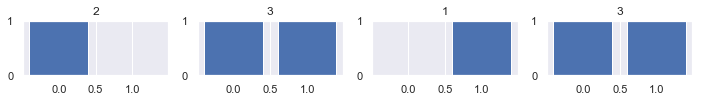

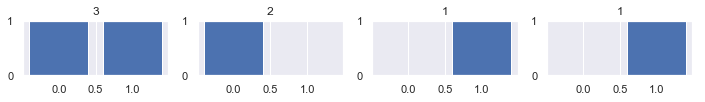

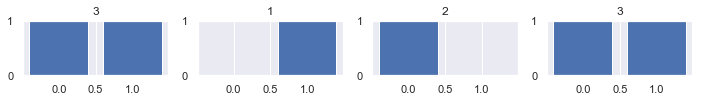

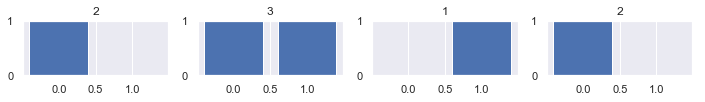

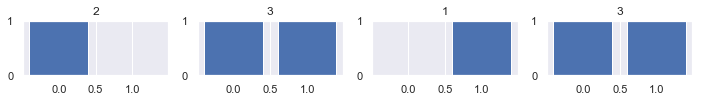

In [144]:
if use_mnist:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for ax, inp, tar in zip(axs, inputs, targets):
        ax.set_title(tar[row].numpy().argmax() + 1)
        if use_mnist:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [145]:
def maybe_mutate_message(
    message, channel_size, history, p_mutate, 
    training=False
):
    batch_size, *_ = tf.shape(message)
    
    if history == []:
        history = [{'message_from_teacher': tf.zeros_like(message)}]

    possible_utts = np.array(range(channel_size))

    prev_utts_batch = tf.convert_to_tensor([
        tf.argmax(item['message_from_teacher'], axis=-1) 
        for item in history 
    ])
    prev_utts_batch = tf.transpose(prev_utts_batch)

    mutations = [
        random.choice(possible_utts[~np.isin(possible_utts, prev_utts)]) 
        for prev_utts in prev_utts_batch
    ]
    if mutations:
        mutations = tf.one_hot(mutations, channel_size)
        mutations = tf.stop_gradient(mutations)

        rand_samples = tf.random.uniform((batch_size, 1))
        mask = tf.cast(rand_samples < p_mutate, tf.float32)

        return mask * mutations + (1 - mask) * message, mask

    return message, None
    

def play_game(
    inputs, teacher, student, comm_channel, 
    p_mutate=0.5, training=False,
    access_to_inputs_in_first_phase=True,
    stop_gradients_on_final_message=False,
    stop_gradients_on_all_comm=False,
    no_protocol_establishment=False,
):
    
    if len(inputs) != num_classes + 1:
        raise ValueError(f'Invalid inputs: {inputs}')

    _, batch_size, *_ = tf.shape(inputs)

    no_inp = tf.zeros_like(inputs[0])
    silence = comm_channel.get_initial_state(batch_size)

    teacher_prev_msg = silence
    history = []
    
    teacher_state = None
    student_state = None

    if not no_protocol_establishment:
        for inp in inputs[:-1]:

            if access_to_inputs_in_first_phase:
                teacher_inputs = (inp, teacher_prev_msg, silence)
            else:
                teacher_inputs = (no_inp, teacher_prev_msg, silence)

            teacher_utterance, _, teacher_state = teacher(
                teacher_inputs, state=teacher_state, training=training
            )

            message_from_teacher = comm_channel(teacher_utterance, 
                                                training=training)
            message_from_teacher, mutations = \
                maybe_mutate_message(message_from_teacher, 
                                     comm_channel.size,
                                     history,
                                     p_mutate,
                                     training=training)
                     
            if stop_gradients_on_all_comm:
                message_from_teacher = tf.stop_gradient(message_from_teacher)

            if access_to_inputs_in_first_phase:
                student_inputs = (inp, silence, message_from_teacher)
            else:
                student_inputs = (no_inp, silence, message_from_teacher)

            _, _, student_state = student(
                student_inputs, state=student_state, training=training
            )

            history.append({
                'teacher_utterance': teacher_utterance,
                'message_from_teacher': message_from_teacher, 
                'message_mutations': mutations
            })
            teacher_prev_msg = message_from_teacher

    teacher_inputs = (inputs[-1], teacher_prev_msg, silence)
    teacher_utterance, _, _ = teacher(
        teacher_inputs, state=teacher_state, training=training
    )

    message_from_teacher = comm_channel(teacher_utterance,
                                        training=training)

    if stop_gradients_on_final_message or stop_gradients_on_all_comm:
        message_from_teacher = tf.stop_gradient(message_from_teacher)

    student_inputs = (no_inp, silence, message_from_teacher)
    _, student_preds, _ = student(
        student_inputs, state=student_state, training=training
    )

    history.append({
        'teacher_utterance': teacher_utterance,
        'message_from_teacher': message_from_teacher, 
        'message_mutations': None
    })

    return student_preds, history

In [146]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[2, 4, 3, 0],
       [3, 0, 2, 1],
       [2, 3, 4, 1],
       [3, 1, 0, 4],
       [4, 3, 0, 1]], dtype=int64)>

## Construct Model

In [147]:
if use_mnist:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    encoder = None

comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

agent_1 = Agent(comm_channel.size, num_classes, encoder=encoder)
agent_2 = Agent(comm_channel.size, num_classes, encoder=encoder)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)

In [148]:
optimizer.get_config()

{'name': 'RMSprop',
 'learning_rate': 0.01,
 'decay': 0.0,
 'rho': 0.9,
 'momentum': 0.0,
 'epsilon': 1e-07,
 'centered': False}

In [207]:
def get_sent_messages(history):
    return tf.convert_to_tensor([
        item['message_from_teacher'] for item in history
    ])


def get_comm_protocol(messages):
    comm_protocol = tf.convert_to_tensor([
        msg for msg in messages[:-1]
    ])
    comm_protocol = tf.einsum('ijk->jik', comm_protocol)
    return comm_protocol


def get_correct_teacher_msg(history, targets):
    messages = get_sent_messages(history)
    comm_protocol = get_comm_protocol(messages)

    # labels for each input in the protocol phase
    protocol_labels = tf.argmax(targets[:-1], axis=-1)
    # labels for the final input
    final_labels = tf.argmax(targets[-1], axis=-1)
    final_labels = tf.reshape(final_labels, (1, batch_size)) 
    idx = protocol_labels == final_labels

    correct_msgs = comm_protocol[tf.transpose(idx)]
    return correct_msgs


def get_expected_student_pred(outputs, targets):
    student_preds, history = outputs

    messages = get_sent_messages(history)
    comm_protocol = get_comm_protocol(messages)
    
    batch_size, *_ = tf.shape(comm_protocol)
    discretised_protocol = tf.argmax(comm_protocol, axis=-1)
    discretised_final_message = tf.argmax(messages[-1], axis=-1)
    discretised_final_message = tf.reshape(discretised_final_message, 
                                           (batch_size, 1))

    idx = discretised_protocol == discretised_final_message
    idx_num = tf.cast(idx, tf.float32) 
    row_sum = tf.reduce_sum(idx_num, axis=-1)
    row_sum = tf.reshape(row_sum, (batch_size, 1))
    dont_know = row_sum == 0.0

    protocol_labels = tf.transpose(tf.argmax(targets[:-1], axis=-1))
    correct_preds = tf.cast(protocol_labels + 1, tf.float32) * idx_num
    correct_preds = tf.cast(correct_preds, tf.int32)
    correct_preds = tf.one_hot(correct_preds - 1, num_classes, axis=-1)

    batch_size, _, pred_size = tf.shape(correct_preds)
    uniform_preds = tf.ones((batch_size, pred_size)) 
    uniform_preds = uniform_preds * tf.cast(dont_know, tf.float32)
    uniform_preds = tf.reshape(uniform_preds, (batch_size, 1, pred_size))

    correct_preds = tf.concat([correct_preds, uniform_preds], axis=-2)
    correct_preds = tf.reduce_sum(correct_preds, axis=-2)

    row_sums = tf.reduce_sum(correct_preds, axis=-1)
    row_sums = tf.reshape(row_sums, (batch_size, 1))
    correct_preds = correct_preds / row_sums
    
    return correct_preds

In [203]:
class SyntheticTeacher:
    
    def __init__(self, channel_size, num_classes, targets):
        self.channel_size = channel_size
        self.num_classes = num_classes
        self.targets = targets
    
    def __call__(self, inputs, state=None, training=False):
        inp, prev_utt, other_utt = inputs
        
        if state is not None:
            history = state
        else:
            history = []
        
        if len(history) < self.num_classes:
            utt, _ = maybe_mutate_message(prev_utt,
                                          self.channel_size,
                                          history,
                                          p_mutate=1)
        else:
            utt = get_correct_teacher_msg(history + [history[0]], 
                                          self.targets)
        
        history.append({
            'message_from_teacher': utt, 
        })
        
        state = history
        
        return 1000*utt, None, state

In [204]:
from tensorflow.keras.losses import categorical_crossentropy as cce


def teacher_loss_fn(outputs, targets):
    student_preds, history = outputs
    return cce(targets[-1], student_preds)
    

def student_loss_fn(outputs, targets):
    student_preds, history = outputs
    expected_preds = get_expected_student_pred(outputs, targets)
    return cce(expected_preds, student_preds)


def compute_gradients(inputs, targets,
                      teacher, student, 
                      student_only=False,
                      teacher_only=False,
                      **play_kwargs):
    
    if student_only and teacher_only:
        raise ValueError('student_only and teacher_only cannot both be true')

    with tf.GradientTape(persistent=True) as tape:
        outputs = play_game(inputs, teacher, student, 
                            comm_channel, training=True, 
                            **play_kwargs)
        if student_only:
            teacher_loss = 0
        else:
            teacher_loss = teacher_loss_fn(outputs, targets)
            
        if teacher_only:
            student_loss = 0
        else:
            student_loss = student_loss_fn(outputs, targets)

    if not teacher_only:
        student_grads = tape.gradient(student_loss, student.trainable_variables)
    else:
        student_grads = None
        
    if not student_only:
        teacher_grads = tape.gradient(teacher_loss, teacher.trainable_variables)
    else:
        teacher_grads = None
    
    return (student_grads, teacher_grads), (student_loss, teacher_loss)

Check gradients:

In [209]:
inputs, targets = generate_train_batch()
(student_grads, teacher_grads), _ = compute_gradients(inputs, targets, agent_1, agent_1)

for v, g in zip(agent_1.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(agent_1.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense_8/kernel:0 teacher grad norm: 2.1909284591674805
agent/dense_8/bias:0 teacher grad norm: 1.8320038318634033
agent/lstm_4/kernel:0 teacher grad norm: 3.8065543174743652
agent/lstm_4/recurrent_kernel:0 teacher grad norm: 1.702720046043396
agent/lstm_4/bias:0 teacher grad norm: 1.4527966976165771
agent/dense_9/kernel:0 teacher grad norm: 1.9348342418670654
agent/dense_9/bias:0 teacher grad norm: 1.6790202856063843

agent/dense_8/kernel:0 student grad norm: 3.2460577487945557
agent/dense_8/bias:0 student grad norm: 4.098245143890381
agent/lstm_4/kernel:0 student grad norm: 6.026153564453125
agent/lstm_4/recurrent_kernel:0 student grad norm: 3.8568084239959717
agent/lstm_4/bias:0 student grad norm: 5.2357988357543945
agent/dense_9/kernel:0 student grad norm: 3.8253190517425537
agent/dense_9/bias:0 student grad norm: 5.740398406982422


In [210]:
agent_1.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate_4 (Concatenate)  multiple                  0         
_________________________________________________________________
lambda_12 (Lambda)           multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  1664      
_________________________________________________________________
lstm_4 (LSTM)                multiple                  49408     
_________________________________________________________________
dense_9 (Dense)              multiple                  520       
_________________________________________________________________
lambda_13 (Lambda)           multiple                  0         
_________________________________________________________________
lambda_14 (Lambda)           multiple                  0     

In [214]:
from matplotlib import gridspec

def plot_game(inputs, outputs, targets, 
              select_batch=0, show_utterances=True):
    """
    Assuming that there is a batch of games, this will only plot
    the first one in the batch
    """
    student_preds, history = outputs
    _, num_classes = tf.shape(student_preds)
    num_classes = int(num_classes)
    student_loss = student_loss_fn(outputs, targets)
    teacher_loss = teacher_loss_fn(outputs, targets)
    
    if len(history) > 1:
        k = 1.5
        fig = plt.figure(
            figsize=(
                int(k*(num_classes+1)), 
                int(k*(comm_channel.size+2))
            )
        )
        n_rows = len(history) + 1
    else:
        fig = plt.figure(figsize=(10, num_classes+1)) 
        n_rows = 2
    
    chan_size, = history[0]['message_from_teacher'][select_batch].shape
    gs = gridspec.GridSpec(n_rows, 3) 

    for i, item in enumerate(history):
        ax0 = plt.subplot(gs[i, :2])
        if show_utterances:
            vals = tf.stack([
                item['message_from_teacher'][select_batch],
                tf.nn.softmax(item['teacher_utterance'][select_batch]),
            ])
            vals = tf.reshape(vals, (np.prod(vals.shape),))
            types = ['message'] * comm_channel.size + ['utterance'] * comm_channel.size
            x = list(range(comm_channel.size))
            x = x+x
        else:
            vals = item['message_from_teacher'][select_batch]
            types = ['message'] * comm_channel.size
            x = list(range(comm_channel.size))
        df = pd.DataFrame({
            'x': x, 'y': vals, 'type': types,
        })
        sns.barplot(data=df, x='x', y='y', hue='type',
                    palette=sns.color_palette()[::-1]);
        ax0.set_xlabel(''); ax0.set_ylabel('')
        if i > 0:
            plt.legend([],[], frameon=False)
        else:
            plt.gca().legend().set_title('')
        
        ax0.set_ylim([0, 1])
        ax0.set_yticks([0, 0.5, 1])
        if i < len(history) - 1:
            did_mutate = 1.0 == item['message_mutations'][select_batch][0]
            ax0.set_title(f'Teacher Message {i+1} (Establishing Protocol Phase)\n'
                          f'Did Mutate = {did_mutate}')
        else:
            ax0.set_title(f'Teacher Message {i+1} (Testing Phase)')

        ax1 = plt.subplot(gs[i, 2])
        if len(history) != len(inputs):
            inp = inputs[-1][select_batch]
        else:
            inp = inputs[i][select_batch]
            
        if use_mnist:
            ax1.imshow(inp)        
            ax1.axis('off')
        else:
            domain = list(range(len(inp)))
            ax1.bar(domain, inp)
            ax1.set_ylim([0, 1])
            ax1.set_yticks([0, 1])
            ax1.set_xticks([0, 1])
        
        tar_cls = tf.argmax(targets[i][select_batch])
        ax1.set_title(f'Input (Class {class_labels[tar_cls]})')

    if n_rows > 2:
        ax = plt.subplot(gs[-1, 0])
        sns.barplot(x=list(range(comm_channel.size)),
                    y=get_correct_teacher_msg(history, targets)[select_batch],
                    palette=sns.color_palette()[:1]);
        ax.set_ylim([0, 1])
        ax.set_yticks([0, 0.5, 1])
        ax.set_title(f'What the teacher should\n'
                     f'have said in message {i+1}\n'
                     f'(Teacher Loss {int(teacher_loss[select_batch]*10000)/10000})')
        ax.set_xlabel('Symbol')
    
    ax = plt.subplot(gs[-1, 1])
    df = pd.DataFrame({
        'x': [str(l) for l in class_labels], 
        'y': student_preds[select_batch]
    })
    sns.barplot(data=df, x='x', y='y');
    ax.set_ylim([0, 1])
    
    ax.set_title(f'What student predicted \n '
                 f'(Student Loss = {int(student_loss[select_batch]*10000)/10000})')
    ax.set_xlabel('Class');  ax.set_ylabel('')
    
    ax = plt.subplot(gs[-1, 2])
    df = pd.DataFrame({
        'x': [str(l) for l in class_labels], 
        'y': get_expected_student_pred(outputs, targets)[select_batch]
    })
    sns.barplot(data=df, x='x', y='y');
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_title(f'What the student should\nhave predicted')
    ax.set_xlabel('Class');  ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

In [215]:
inputs, targets = generate_train_batch()
student = agent_1
teacher = SyntheticTeacher(comm_channel.size,
                           num_classes,
                           targets)
outputs = play_game(inputs, teacher, student,
                    comm_channel, p_mutate=0, training=True)

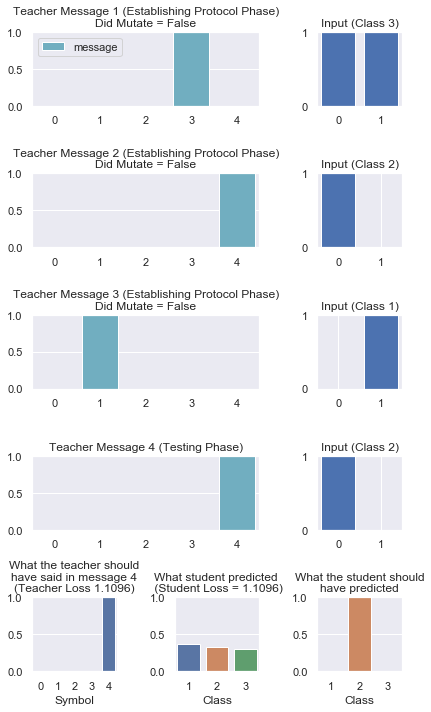

In [216]:
plot_game(inputs, outputs, targets, select_batch=1, show_utterances=False)

In [217]:
tb_callback = tf.keras.callbacks.TensorBoard()
epochs = 10
steps_per_epoch = 100
step_print_freq = 5

def print_history():
    for e, item in enumerate(training_history):
        mins = int(item['seconds_taken']) // 60
        secs = int(item['seconds_taken']) % 60
        t = f'{mins}:{secs}'
        l = int(10000 * item['loss'].numpy().mean()) / 10000
        print(f'Epoch {e}, Time Taken (mm:ss): {t}, Loss: {l}')


def print_step_progress(step, step_mean_loss):
    l = int(10000 * step_mean_loss.numpy().mean()) / 10000
    p = int(10000 * step/steps_per_epoch) / 100
    print(f'Epoch {epoch}, {p}% complete, Loss: {l}')
    

def self_play_training_step(agent):
    
    (grads_s, grads_t), (loss_s, loss_t) = compute_gradients(agent, agent)
    optimizer.apply_gradients(zip(grads_s, agent.trainable_variables))
    optimizer.apply_gradients(zip(grads_t, agent.trainable_variables))
    
    return loss_s + loss_t
        
def only_student_training_step(agent):
    inputs, targets = generate_train_batch()
    teacher = SyntheticTeacher(comm_channel.size, num_classes, targets)
    (grads_s, _), (loss_s, _) = compute_gradients(inputs, targets,
                                                  teacher, agent,
                                                  student_only=True,
                                                  stop_gradients_on_all_comm=True,
                                                  p_mutate=0)
    optimizer.apply_gradients(zip(grads_s, agent.trainable_variables))

    return loss_s

In [218]:
epoch = 0
training_step = lambda: only_student_training_step(agent_1)
training_history = []

In [219]:
print_history()
try:
    while epoch < epochs:
        mean_loss = tf.zeros((1,))
        
        start_time = time.time()
        for step in range(steps_per_epoch):
            
            loss = training_step()
            mean_loss = (mean_loss + tf.reduce_mean(loss)) / 2.0

            if step % step_print_freq == 0:
                print_history()
                print_step_progress(step, mean_loss)
                clear_output(wait=True)
        
        seconds_taken = time.time() - start_time
        training_history.append({
            'loss': mean_loss, 
            'seconds_taken': seconds_taken
        })
        
        epoch += 1
        print_history()
        clear_output(wait=True)

except KeyboardInterrupt:
    pass

print_history()
print('Training stopped.')

Epoch 0, Time Taken (mm:ss): 0:15, Loss: 0.9685
Epoch 1, Time Taken (mm:ss): 0:14, Loss: 0.4211
Epoch 2, Time Taken (mm:ss): 0:13, Loss: 0.0637
Epoch 3, Time Taken (mm:ss): 0:18, Loss: 0.0693
Epoch 4, Time Taken (mm:ss): 0:17, Loss: 0.0208
Epoch 5, Time Taken (mm:ss): 0:15, Loss: 0.004
Epoch 6, Time Taken (mm:ss): 0:19, Loss: 0.0014
Epoch 7, Time Taken (mm:ss): 0:17, Loss: 0.0004
Epoch 8, Time Taken (mm:ss): 0:18, Loss: 0.0028
Epoch 9, Time Taken (mm:ss): 0:15, Loss: 0.0017
Training stopped.


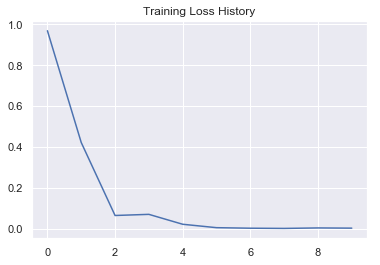

In [220]:
plt.figure()
plt.title('Training Loss History')
sns.lineplot(x=range(len(training_history)), 
             y=[item['loss'].numpy()[0] for item in training_history]);

In [221]:
tf.shape(inputs)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>

In [222]:
def student_only_test_play(inputs, targets):
    teacher = SyntheticTeacher(comm_channel.size, num_classes, targets)
    student = agent_1
    return play_game(inputs, teacher, student, 
                     comm_channel, training=False,
                     p_mutate=0)

test_play = student_only_test_play

test_loss = tf.zeros((1,))
for step in range(50):
    inputs, targets = generate_test_batch()
    outputs = test_play(inputs, targets)
    loss_s = student_loss_fn(outputs, targets)
    loss_t = student_loss_fn(outputs, targets)
    test_loss = (test_loss + tf.reduce_mean(loss_s + loss_t)) / 2
    
print(test_loss)

tf.Tensor([5.2294716e-05], shape=(1,), dtype=float32)


In [223]:
from sklearn.metrics import plot_confusion_matrix

In [224]:
test_samples = [generate_test_batch() for _ in range(50)]

games_played = [
    (x, y, *test_play(x, y))
    for x, y in test_samples
]

labels = tf.concat([
    tf.argmax(y[-1], axis=-1) 
    for _, y in test_samples
], axis=0)

preds = tf.concat([
    tf.argmax(student_preds, axis=-1) 
    for _, _, student_preds, _ in games_played
], axis=0)

conf_matrix = tf.math.confusion_matrix(labels, preds)

col_totals = tf.reduce_sum(conf_matrix, axis=0)
col_totals = tf.repeat(col_totals, tf.shape(conf_matrix)[0])
col_totals = tf.reshape(col_totals, tf.shape(conf_matrix))
col_totals = tf.transpose(col_totals)

conf_matrix = (conf_matrix / col_totals).numpy()
conf_matrix[np.where(np.isnan(conf_matrix))] = 0

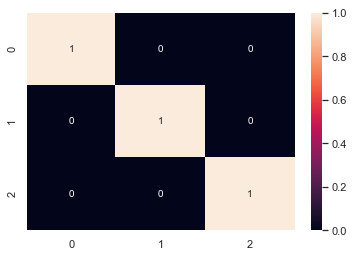

In [225]:
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1);

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

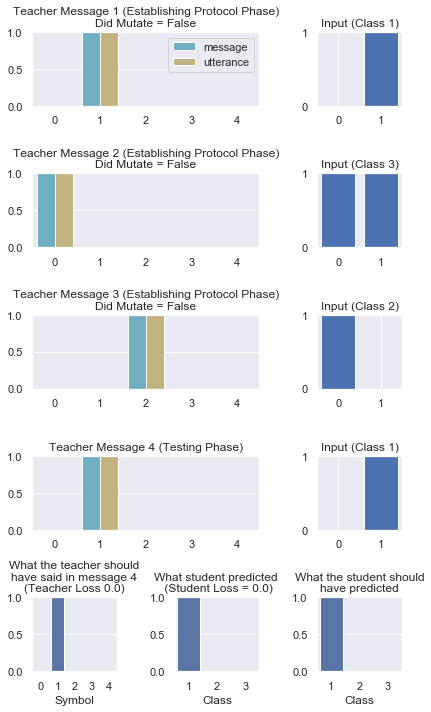

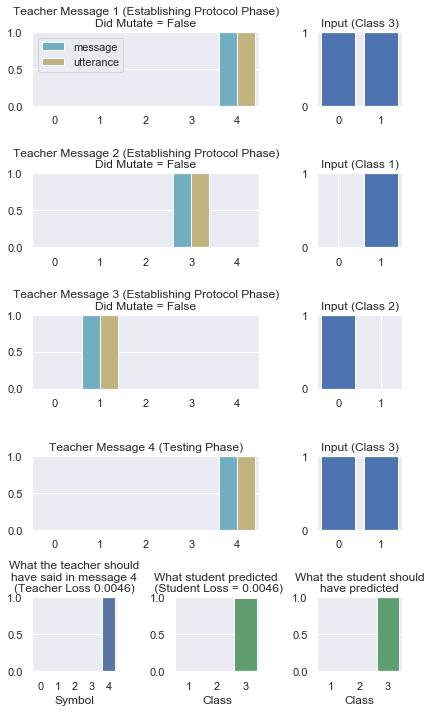

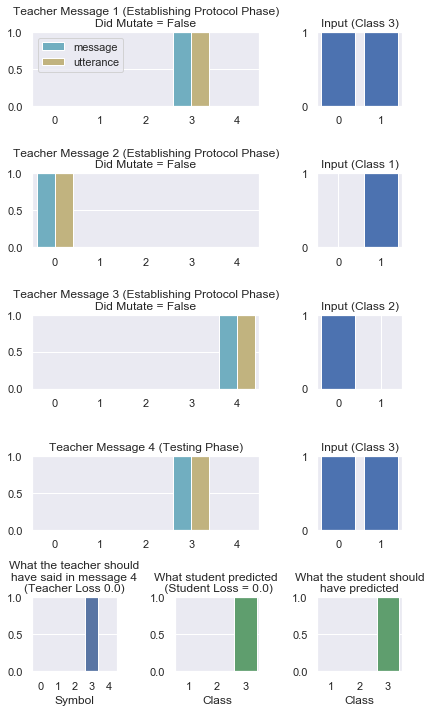

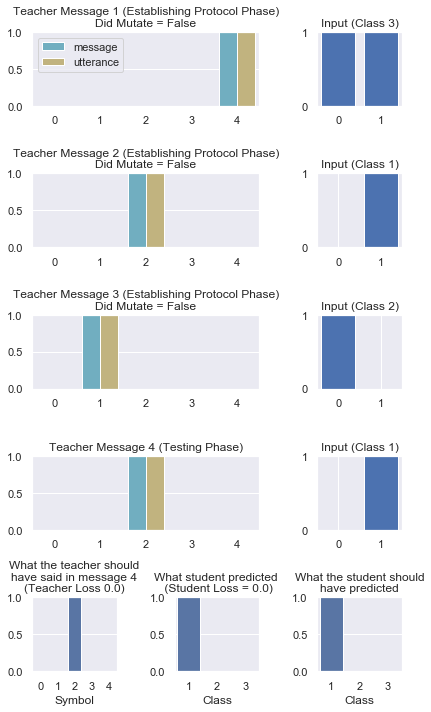

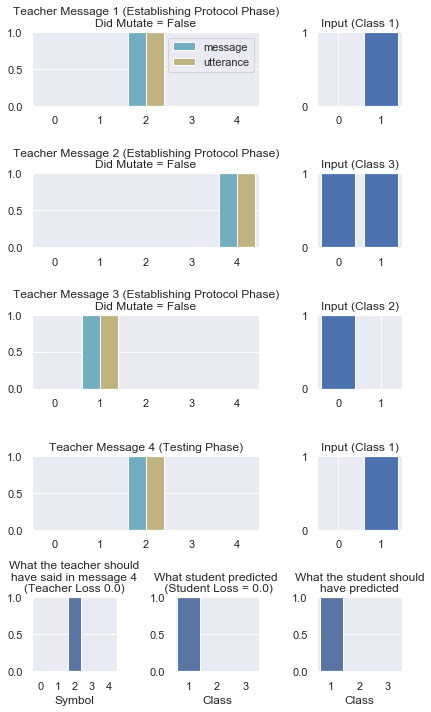

In [226]:
for i in range(5):
    inputs, targets, *outputs = games_played[5+i]
    plot_game(inputs, outputs, targets)

In [227]:
messages = tf.concat([
    history[-1]['message_from_teacher'] 
    for *_, history in games_played
], axis=0)

In [228]:
def make_lm_map(label, message):
    *_, msg_size = tf.shape(message)
    lm_map_shape = (num_classes, msg_size)
    class_indices = [i for i, _ in enumerate(class_labels)]
    indices = tf.reshape(tf.repeat(class_indices, msg_size), lm_map_shape)
    indices = tf.cast(indices, tf.int64) == label
    return message * tf.cast(indices, tf.float32)
    
*_, msg_size = tf.shape(messages)
lm_map = tf.zeros((num_classes, msg_size))
for label, message in zip(labels, messages):
    lm_map = lm_map + make_lm_map(label, message)

row_totals = tf.reduce_sum(lm_map, axis=1)
row_totals = tf.repeat(row_totals, comm_channel.size)
row_totals = tf.reshape(row_totals, tf.shape(lm_map))

lm_map = lm_map / row_totals

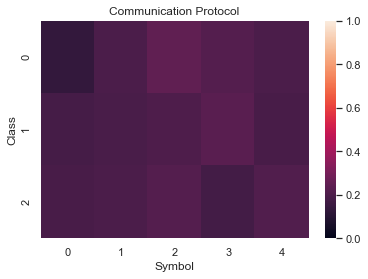

In [229]:
sns.heatmap(lm_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [44]:
# weights_file = f'models/test/{int(time.time())}'
# weights_file

In [45]:
# model.save_weights(weights_file)

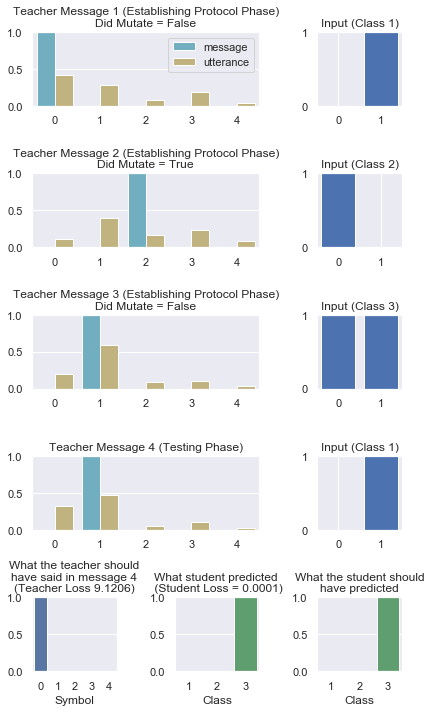

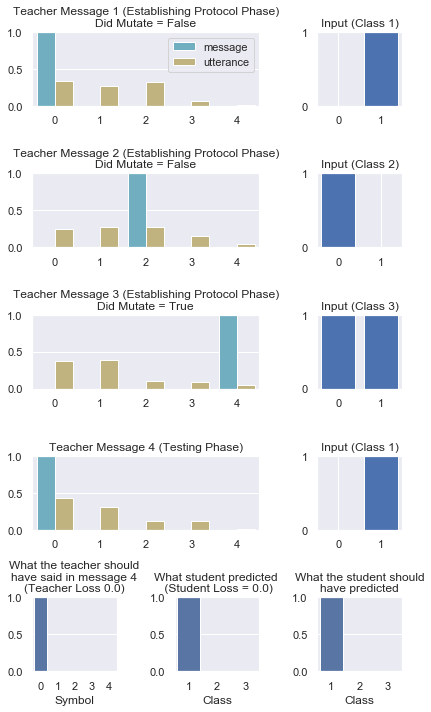

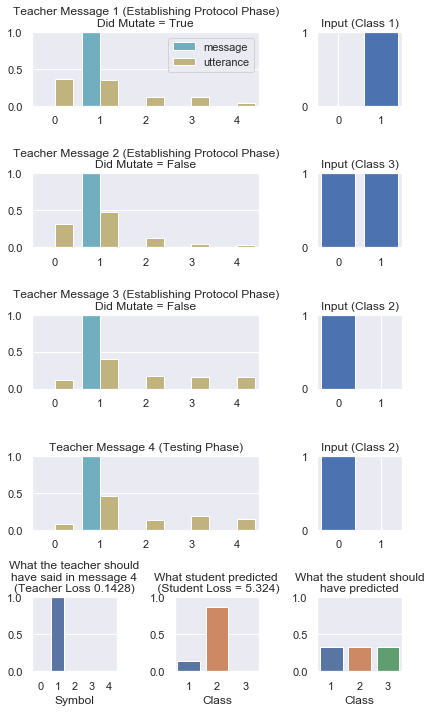

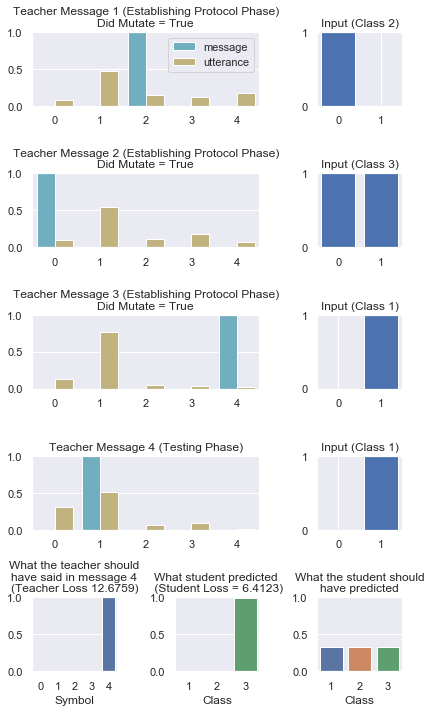

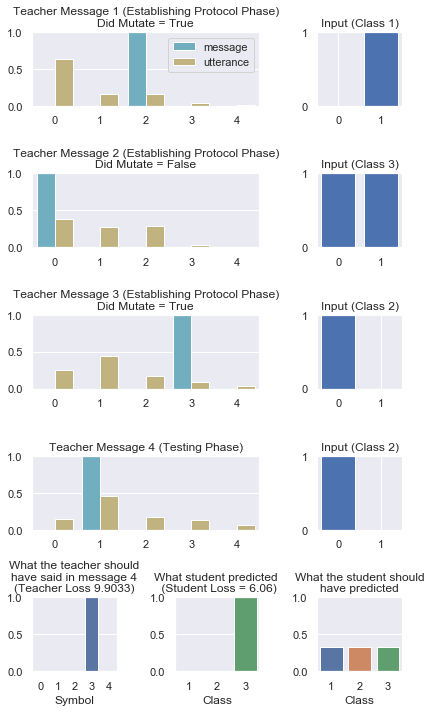

In [230]:
for i in range(5):
    inputs, targets = generate_test_batch()
    outputs = play_game(inputs, agent_1, agent_1, comm_channel)
    plot_game(inputs, outputs, targets)